<a href="https://colab.research.google.com/github/shreyamaurya029/AI-vs-Human-/blob/main/CNNBiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load the datasets
train_df = pd.read_csv('/content/drive/MyDrive/traindataset.csv')
test_df = pd.read_csv('/content/drive/MyDrive/testdataset.csv')

In [ ]:
# Fill missing values and ensure text is of string type for train_df
train_df['Text'].fillna('', inplace=True)
train_df['Text'] = train_df['Text'].astype(str)

# Fill missing values and ensure text is of string type for test_df
test_df['Text'].fillna('', inplace=True)
test_df['Text'] = test_df['Text'].astype(str)

In [ ]:
# Preprocess the data
text_column = 'Text'
label_column = 'Label'
feature_columns = ['Vocab Size', 'Avg Word Length', 'Density', 'active',
       'passive', 'noun', 'pron', 'verb', 'adj', 'adv', 'det', 'propn', 'part',
       'intj', 'punct', 'Flesch Reading Ease',
       'Gunning Fog Index', 'Perplexity' , 'Burstness']


In [ ]:
# Scale features
scaler = StandardScaler()
train_df[feature_columns] = scaler.fit_transform(train_df[feature_columns])
test_df[feature_columns] = scaler.transform(test_df[feature_columns])

In [ ]:
class CNNBiLSTMWithFeatures(nn.Module):
    def __init__(self, vocab_size, embedding_dim, feature_dim, num_filters, filter_sizes, lstm_hidden_dim, num_classes):
        super(CNNBiLSTMWithFeatures, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        self.lstm = nn.LSTM(num_filters * len(filter_sizes), lstm_hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim * 2 + feature_dim, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_ids, additional_features):
        embedded = self.embedding(input_ids)
        embedded = embedded.permute(0, 2, 1)  # (batch, embedding_dim, seq_len)

        conv_outputs = []
        for conv in self.convs:
            conv_output = nn.functional.relu(conv(embedded))
            conv_output = nn.functional.max_pool1d(conv_output, conv_output.shape[2]).squeeze(2)
            conv_outputs.append(conv_output)

        x = torch.cat(conv_outputs, dim=1)
        x = x.unsqueeze(1)  # Add sequence length dimension

        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out.squeeze(1)

        combined = torch.cat((lstm_out, additional_features), dim=1)
        combined = self.dropout(combined)
        logits = self.fc(combined)

        return logits


In [ ]:
class SimpleTokenizer:
    def __init__(self, texts, max_vocab_size=10000):
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.build_vocab(texts, max_vocab_size)

    def build_vocab(self, texts, max_vocab_size):
        word_freq = {}
        for text in texts:
            for word in text.split():
                word_freq[word] = word_freq.get(word, 0) + 1

        sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
        for word, _ in sorted_words[:max_vocab_size-2]:
            idx = len(self.word2idx)
            self.word2idx[word] = idx
            self.idx2word[idx] = word

    def encode(self, text, max_length=512, padding='max_length', truncation=True):
        tokens = [self.word2idx.get(word, 1) for word in text.split()]
        if truncation:
            tokens = tokens[:max_length]
        if padding == 'max_length':
            tokens = tokens + [0] * (max_length - len(tokens))
        return tokens

    def vocab_size(self):
        return len(self.word2idx)


In [ ]:
class CombinedDataset(Dataset):
    def __init__(self, texts, additional_features, labels, tokenizer):
        self.texts = texts
        self.additional_features = additional_features
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        features = self.additional_features[idx]
        label = self.labels[idx]

        input_ids = self.tokenizer.encode(text, max_length=512, padding='max_length', truncation=True)

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'additional_features': torch.tensor(features, dtype=torch.float),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
# Create datasets and dataloaders
tokenizer = SimpleTokenizer(train_df[text_column].tolist())

train_dataset = CombinedDataset(
    texts=train_df[text_column].tolist(),
    additional_features=train_df[feature_columns].values,
    labels=train_df[label_column].tolist(),
    tokenizer=tokenizer
)

test_dataset = CombinedDataset(
    texts=test_df[text_column].tolist(),
    additional_features=test_df[feature_columns].values,
    labels=test_df[label_column].tolist(),
    tokenizer=tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Model parameters
vocab_size = tokenizer.vocab_size()
embedding_dim = 100
feature_dim = len(feature_columns)
num_filters = 100
filter_sizes = [3, 4, 5]
lstm_hidden_dim = 128
num_classes = 2


In [ ]:
# Initialize model, optimizer, and loss function
model = CNNBiLSTMWithFeatures(vocab_size, embedding_dim, feature_dim, num_filters, filter_sizes, lstm_hidden_dim, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids = batch['input_ids'].to(device)
        additional_features = batch['additional_features'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, additional_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/10: 100%|██████████| 1369/1369 [10:10<00:00,  2.24it/s]


Epoch 1/10, Loss: 0.0045


Epoch 2/10: 100%|██████████| 1369/1369 [10:15<00:00,  2.23it/s]


Epoch 2/10, Loss: 0.0052


Epoch 3/10: 100%|██████████| 1369/1369 [10:12<00:00,  2.24it/s]


Epoch 3/10, Loss: 0.0038


Epoch 4/10: 100%|██████████| 1369/1369 [10:05<00:00,  2.26it/s]


Epoch 4/10, Loss: 0.0040


Epoch 5/10: 100%|██████████| 1369/1369 [10:08<00:00,  2.25it/s]


Epoch 5/10, Loss: 0.0034


Epoch 6/10: 100%|██████████| 1369/1369 [10:09<00:00,  2.25it/s]


Epoch 6/10, Loss: 0.0038


Epoch 7/10: 100%|██████████| 1369/1369 [10:23<00:00,  2.20it/s]


Epoch 7/10, Loss: 0.0023


Epoch 8/10: 100%|██████████| 1369/1369 [10:15<00:00,  2.22it/s]


Epoch 8/10, Loss: 0.0022


Epoch 9/10: 100%|██████████| 1369/1369 [10:15<00:00,  2.22it/s]


Epoch 9/10, Loss: 0.0025


Epoch 10/10: 100%|██████████| 1369/1369 [10:14<00:00,  2.23it/s]

Epoch 10/10, Loss: 0.0010


In [ ]:
# Evaluation on test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        additional_features = batch['additional_features'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, additional_features)
        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


In [ ]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
class_report = classification_report(true_labels, predictions, target_names=['Human', 'Machine'])

Test Accuracy: 0.9936
Test Precision: 0.9951
Test Recall: 0.9922
Test F1-Score: 0.9936

Classification Report:
              precision    recall  f1-score   support

       Human       0.99      1.00      0.99      2432
     Machine       1.00      0.99      0.99      2432

    accuracy                           0.99      4864
   macro avg       0.99      0.99      0.99      4864
weighted avg       0.99      0.99      0.99      4864



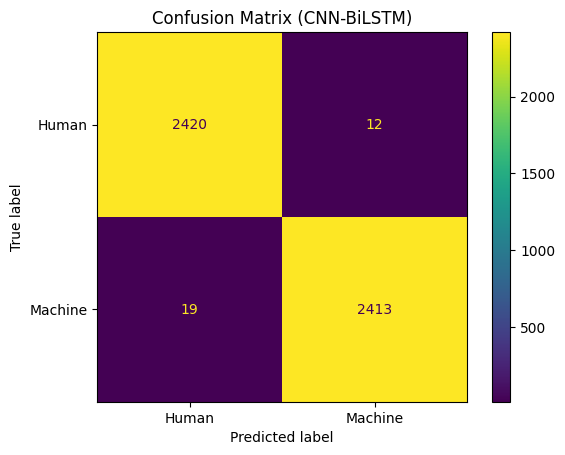

In [ ]:

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(class_report)

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
ConfusionMatrixDisplay(cm, display_labels=['Human', 'Machine']).plot()
plt.title('Confusion Matrix (CNN-BiLSTM)')
plt.show()

Test Accuracy: 0.9936
Test Precision: 0.9951
Test Recall: 0.9922
Test F1-Score: 0.9936

Classification Report:
              precision    recall  f1-score   support

       Human       0.99      1.00      0.99      2432
     Machine       1.00      0.99      0.99      2432

    accuracy                           0.99      4864
   macro avg       0.99      0.99      0.99      4864
weighted avg       0.99      0.99      0.99      4864



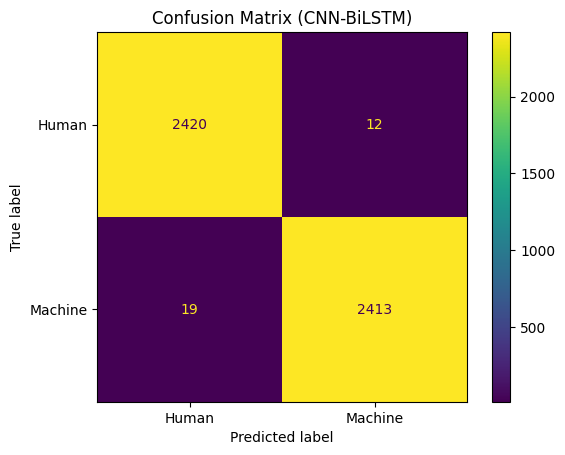

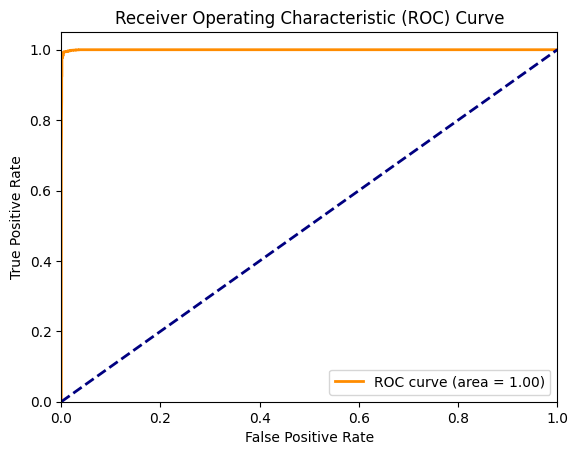

AUC-ROC: 0.9996


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Evaluation on test set
model.eval()
predictions = []
true_labels = []
probabilities = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        additional_features = batch['additional_features'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, additional_features)
        _, predicted = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        probabilities.extend(probs[:, 1].cpu().numpy())  # Probability of positive class

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
class_report = classification_report(true_labels, predictions, target_names=['Human', 'Machine'])

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(class_report)

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
ConfusionMatrixDisplay(cm, display_labels=['Human', 'Machine']).plot()
plt.title('Confusion Matrix (CNN-BiLSTM)')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC: {roc_auc:.4f}")

Evaluating on training data:
Training Accuracy: 0.9999
Training Precision: 0.9999
Training Recall: 0.9999
Training F1-Score: 0.9999

Training Classification Report:
              precision    recall  f1-score   support

       Human       1.00      1.00      1.00     21890
     Machine       1.00      1.00      1.00     21890

    accuracy                           1.00     43780
   macro avg       1.00      1.00      1.00     43780
weighted avg       1.00      1.00      1.00     43780


Evaluating on test data:
Test Accuracy: 0.9936
Test Precision: 0.9936
Test Recall: 0.9936
Test F1-Score: 0.9936

Test Classification Report:
              precision    recall  f1-score   support

       Human       0.99      1.00      0.99      2432
     Machine       1.00      0.99      0.99      2432

    accuracy                           0.99      4864
   macro avg       0.99      0.99      0.99      4864
weighted avg       0.99      0.99      0.99      4864



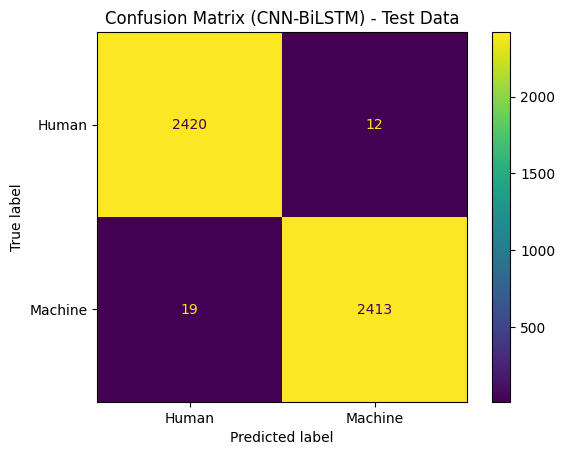

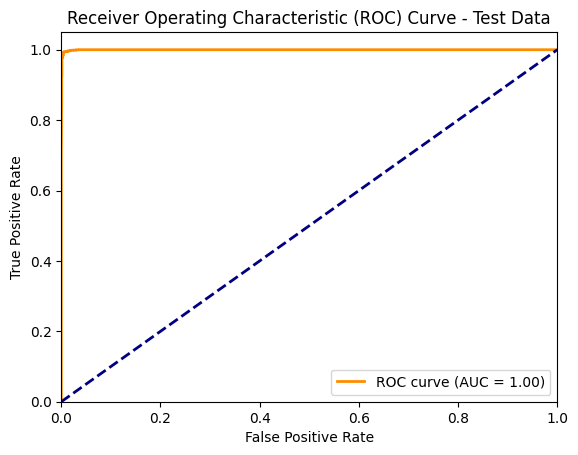

AUC-ROC: 0.9996


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            additional_features = batch['additional_features'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, additional_features)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    return true_labels, predictions, accuracy, precision, recall, f1

# After training the model

# Evaluate on training data
print("Evaluating on training data:")
train_true, train_pred, train_acc, train_prec, train_rec, train_f1 = evaluate_model(model, train_loader, device)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Training Precision: {train_prec:.4f}")
print(f"Training Recall: {train_rec:.4f}")
print(f"Training F1-Score: {train_f1:.4f}")
print("\nTraining Classification Report:")
print(classification_report(train_true, train_pred, target_names=['Human', 'Machine']))

# Evaluate on test data
print("\nEvaluating on test data:")
test_true, test_pred, test_acc, test_prec, test_rec, test_f1 = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, target_names=['Human', 'Machine']))

# Confusion Matrix for test data
cm = confusion_matrix(test_true, test_pred)
ConfusionMatrixDisplay(cm, display_labels=['Human', 'Machine']).plot()
plt.title('Confusion Matrix (CNN-BiLSTM) - Test Data')
plt.show()

# ROC Curve for test data
model.eval()
test_probs = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        additional_features = batch['additional_features'].to(device)
        outputs = model(input_ids, additional_features)
        probs = torch.softmax(outputs, dim=1)
        test_probs.extend(probs[:, 1].cpu().numpy())

fpr, tpr, _ = roc_curve(test_true, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

print(f"AUC-ROC: {roc_auc:.4f}")